# Project Overview

This project aims to optimize the allocation of funds within a portfolio selection.

This will be explored by leveraging the following techniques:
- Sharpe Ratio
- Monte Carlo Method
- Volatlity
- Efficient Fronter (Modern Portfolio Theory)

## Our Imports

In [3]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import scipy.optimize as sco

plt.style.use('fivethirtyeight')
np.random.seed(777)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Get Data

For this project, we will be leveraging quandl and its free API service to retrieve stock information. AlphaVantage's API was helpful in the previous project but it had some limitations regarding accessing data information and setting data ranges. So we will use quandl's service moving forward.

In [9]:
quandl.ApiConfig.api_key = '7WKTSM5hsNzzZcRhg3Zq'
stocks = ['AAPL','AMZN','GOOGL','FB']
data = quandl.get_table('WIKI/PRICES', ticker = stocks,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2016-1-1', 'lte': '2017-12-31' }, paginate=True)
data.head()

,date,ticker,adj_close
None,,,
0,2017-12-29,GOOGL,1053.40
1,2017-12-28,GOOGL,1055.95
2,2017-12-27,GOOGL,1060.20
3,2017-12-26,GOOGL,1065.85
4,2017-12-22,GOOGL,1068.86


Text(0,0.5,'price in $')

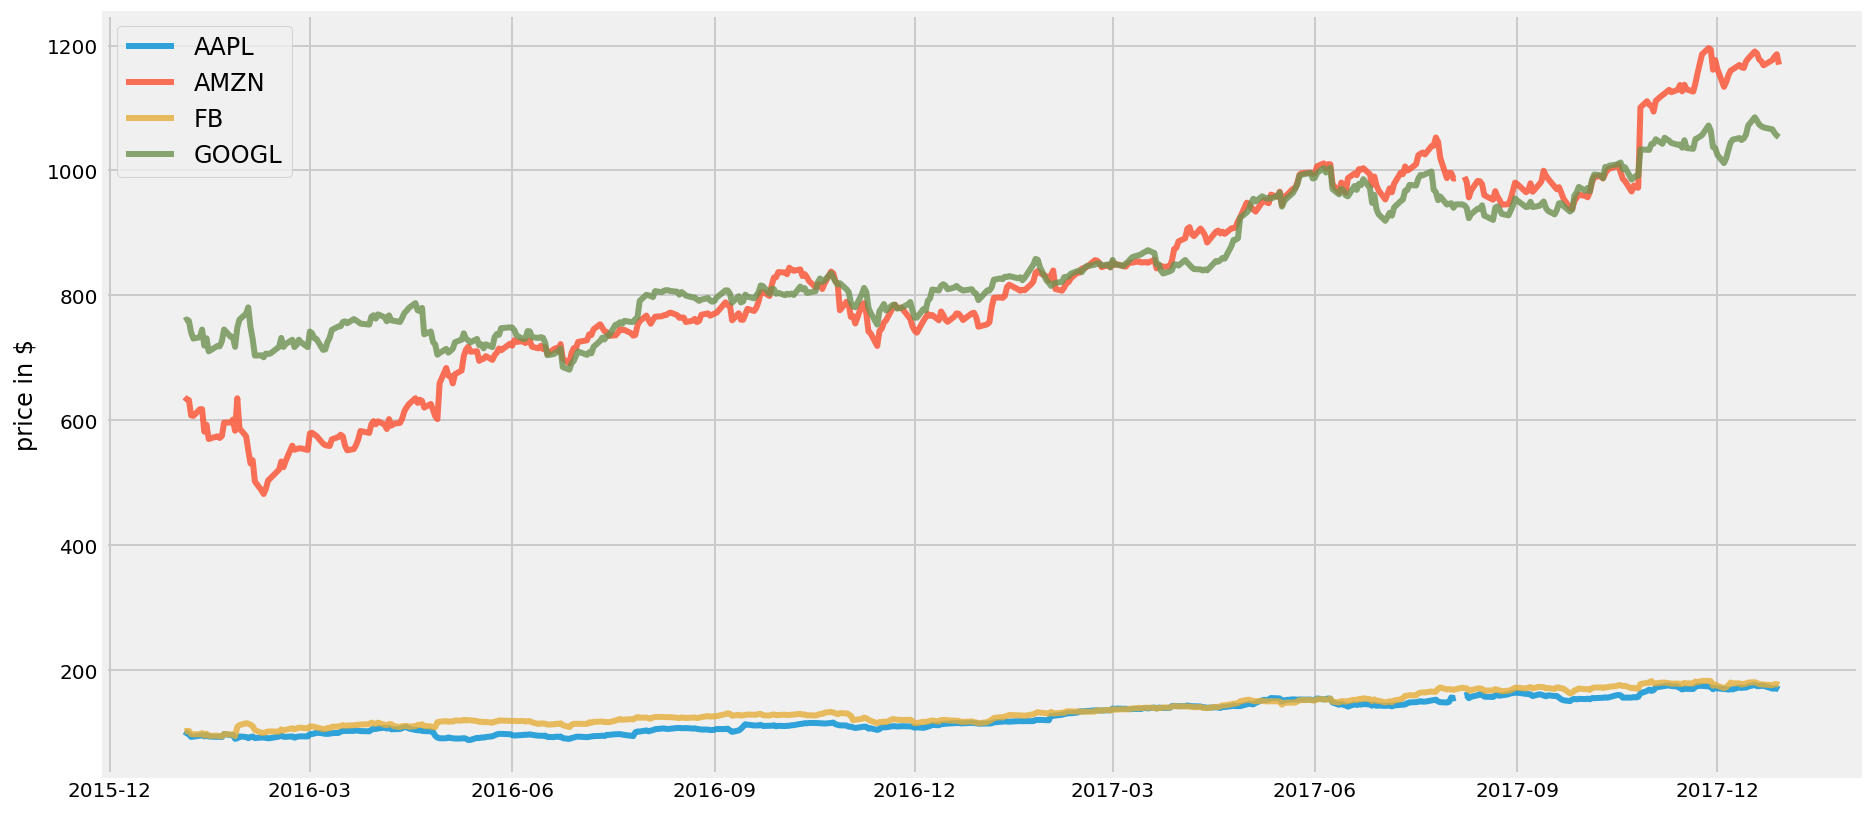

In [12]:
df = data.set_index('date')
df.head()
table = df.pivot(columns='ticker')
# By specifying col[1] in below list comprehension
# You can select the stock names under multi-level column
table.columns = [col[1] for col in table.columns]
table.head()
plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

## Establish Our Portfolio

We will be extending the function used in the PortfolioEvaluator project file to help establish our portfolio.

In [ ]:
import time

#store data here to avoid API usage
stockDataList = []

def portfolioStatistics(inputStocks, stocksAlloc): 
    
    ts = TimeSeries(key='R9PCESGM8SQRD71G', output_format='pandas', indexing_type='date')    
    
    dailyReturn = 0
    sharpeRatio = 0
    stdDailyReturn = 0
    cumulativeReturn = 0
    stdDailyReturn = 0
    
    for stockName in inputStocks: #store data to a list so we don't abuse API call
        stockDataList.append(ts.get_daily_adjusted(stockName, outputsize='compact')[0]['5. adjusted close'])
        time.sleep(1) #delay to prevent timeout issues
        
    for x in range(len(inputStocks)):
        dailyReturn += get_daily_returns(stockDataList[x]).mean() * stocksAlloc[x]
        cumulativeReturn += cumReturn(stockDataList[x]) * stocksAlloc[x]
        stdDailyReturn += get_daily_returns(stockDataList[x]).std() * stocksAlloc[x]
        #print (get_daily_returns(stockDataList[x]).mean() * stocksAlloc[x])
        
    sharpeRatio = np.sqrt(100) * (dailyReturn/stdDailyReturn)
    
    print ("====================Welcome to your portfolio!====================")
    print ("Start Date: 2019-01-02")
    print ("End Date: 2019-05-24")
    print ("Stock Assets: {0}".format(inputStocks))
    print ("Stock Allocations: {0}".format(stocksAlloc))
    print ("Sharpe Ratio: {0}".format(sharpeRatio))
    print ("Volatility / std of daily returns: {0}".format(stdDailyReturn))
    print ("Average Daily Return: {0}".format(dailyReturn))
    print ("Cumulative Return: {0}".format(cumulativeReturn))
    print ("=========================Make some money!=========================")
    
            

inputStocks = ['MSFT','AAPL', 'GOOGL', 'TSLA']
stocksAlloc = [0.5,0.25,0.3,0.1]
portfolioStatistics(inputStocks, stocksAlloc)

## Get Daily Portfolio Value

We will again be extending the function used in the PortfolioEvaluator project file to get the daily portfolio values.

In [ ]:
def dailyPortfolioValue(stockDataList):
    tempStockList = stockDataList
    tempCryptoList = cryptoDataList
    
    for x in range (len(tempStockList)):
        for y in range(len(tempStockList[x])):
            tempStockList[x][y] = tempStockList[x][y] * stocksAlloc[x]

    for x in range (len(tempStockList)):
        for y in range(len(tempStockList[x])):
            tempStockList[0][y] += tempStockList[x][y] 
                        
    ourPortfolio = pd.DataFrame(tempStockList[0])

    return ourPortfolio

## Chart Our Portfolio

Here we will chart our unoptimized portfolio against the SPY to see how it's performing.

In [ ]:
df_temp = pd.concat([ourPortfolio['5. adjusted close'], SPY[0]['5. adjusted close']], keys=['Our Portfolio', 'SPY'], axis=1)

df_temp = df_temp/df_temp.iloc[0,:]
plt.grid()
ax = df_temp['Our Portfolio'].plot(color='blue', grid=True, label='Our Portfolio')
ax = df_temp['SPY'].plot(color='green', grid=True, label='SPY')
ax.set_xlabel("Date")
ax.set_ylabel("Normalized Value")
plt.legend()
plt.show()

# Sharpe Ratio Optimization

## Maximimze for Sharpe Ratio

Now we will create our maximizer function to maximime for the sharpe ratio. 

If you recall, the sharpe ratio is simply: 

![title](https://www.macroption.com/images/formulas/sharpe-ratio-formula-explained.png)

## Optimize Using Sharpe Ratio

Now let's optimize our portfolio for the maximum possible sharpe ratio.

## Normalize and Plot Our Optimized Portfolio

Looking to the charts...

# Volatility Optimization

# Efficient Frontier Optimization

# Monte Carlo Optimization

## Maximize for Monte Carlo

## Optimize Using Monte Carlo

## Normalize and Plot Our Optimized Portfolio